* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from tqdm.notebook import tqdm

In [3]:
# These paths are hardcoded for my system, change as needed.
crohme_extractor_dir = 'C:\\Users\\Jamin Chen\\Development\\CROHME_extractor'

train_path = os.path.join(crohme_extractor_dir, 'outputs', 'train', 'train.pickle')
test_path = os.path.join(crohme_extractor_dir, 'outputs', 'test', 'test.pickle')
classes_path = os.path.join(crohme_extractor_dir, 'classes.txt')

After unpickling, `train_set` and `test_set` will be lists, where each element is a dictionary that has keys `features` and `labels`. `features` will be a 1D numpy array of 1's and 0's, with size `box_size * box_size` where `box_size` is the size of the image. `label` will be a one-hot-encoded array.

In [4]:
# Load pickled data
with open(train_path, 'rb') as train:
    print('Restoring training set ...')
    train_set = pickle.load(train)
    print(f'{len(train_set)} token-level training examples.\n')

with open(test_path, 'rb') as test:
    print('Restoring test set ...')
    test_set = pickle.load(test)
    print(f'{len(test_set)} token-level test examples.\n')
    
classes = open(classes_path, 'r').read().split()
print(f'{len(classes)} classes.')

Restoring training set ...
25419 token-level training examples.

Restoring test set ...
3055 token-level test examples.

26 classes.


In [5]:
def encode_ohe(class_name, classes):
    one_hot = np.zeros(shape=(len(classes)), dtype=np.int8)
    class_index = classes.index(class_name)
    one_hot[class_index] = 1

    return one_hot

def decode_ohe(one_hot, classes):
    index = one_hot.argmax()
    return classes[index]

Label: x


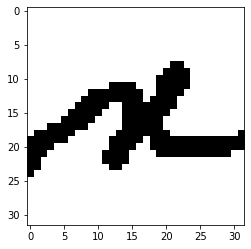

In [6]:
# Code just to show a single image and the class associated with it.
i = 7

features = test_set[i]['features']
label = test_set[i]['label']

box_size = int(np.sqrt(features.shape[0]))
plt.imshow(features.reshape((box_size, box_size)), cmap='gray')
print(f'Label: {decode_ohe(label, classes)}')

In [7]:
class MathTokensDataset(Dataset):
    """
    Dataset containing math tokens extracted from the CROHME 2011, 2012, and 2013 datasets.
    """
    
    def __init__(self, pickle_file, image_size, transform=None):
        """
        Args:
            pickle_file (string): Path to dataset pickle file.
            transform (callable, optional): Optional transform to be applied
                    on a sample.
        """
        with open(pickle_file, 'rb') as f:
            self.df_data = pd.DataFrame(pickle.load(f))
        
        # Reshape features to 3D tensor.
        self.df_data['features'] = self.df_data['features'].apply(lambda vec: vec.reshape(1, image_size, image_size))
        
        # Convert one-hot labels to numbers (PyTorch expects this).
        self.df_data['label'] = self.df_data['label'].apply(lambda ohe_vec: np.argmax(ohe_vec))

        self.transform = transform
    
    def __len__(self):
        return len(self.df_data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = {
            'features': self.df_data.iloc[idx]['features'],
            'label': self.df_data.iloc[idx]['label']
        }
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [8]:
class BaselineTokenCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineTokenCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5)
        self.fc1 = nn.Linear(8 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, num_classes)
        
    def forward(self, x):
        x = x.float()
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 8 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
image_size = 32

train_set = MathTokensDataset(train_path, image_size)
test_set = MathTokensDataset(test_path, image_size)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=0)

In [10]:
# Set device to GPU if available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
num_epochs = 5

net = BaselineTokenCNN(num_classes=len(classes))
net.to(device)  # Send to GPU.

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_loss_history = []

for epoch in tqdm(range(num_epochs)):
    
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        # Get the inputs and send to GPU if available.
        features = data['features'].to(device)
        labels = data['label'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # save statistics
        
        train_loss_history.append(loss.item())
        
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

print('Finished Training')



Finished Training


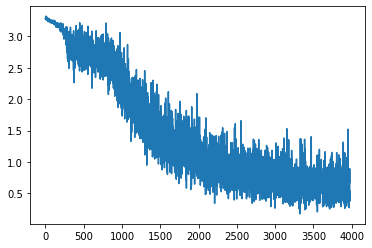

In [12]:
plt.plot(train_loss_history)

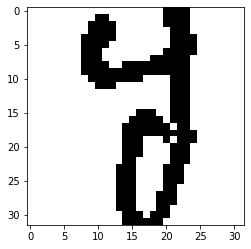

Predicted = y, Actual = y


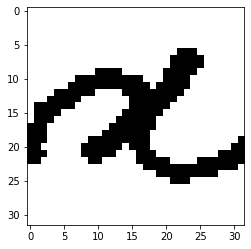

Predicted = x, Actual = x


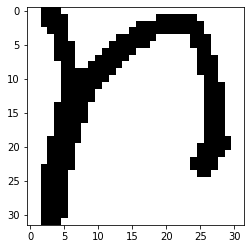

Predicted = n, Actual = n


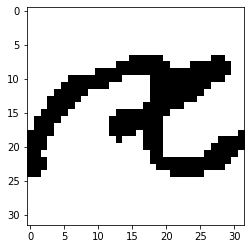

Predicted = n, Actual = x


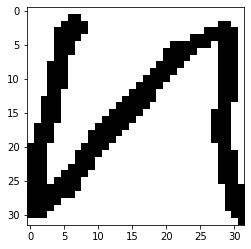

Predicted = n, Actual = n


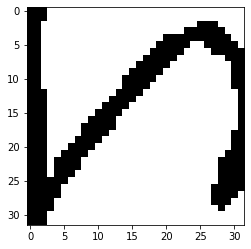

Predicted = n, Actual = n


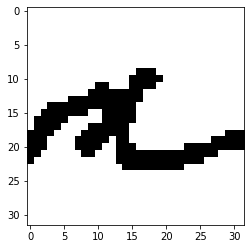

Predicted = i, Actual = x


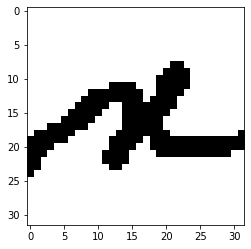

Predicted = x, Actual = x


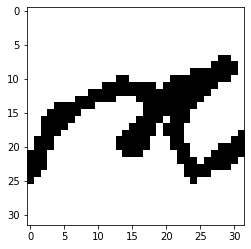

Predicted = x, Actual = x


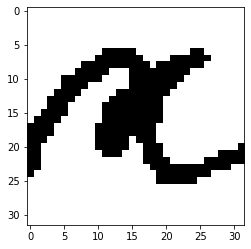

Predicted = x, Actual = x


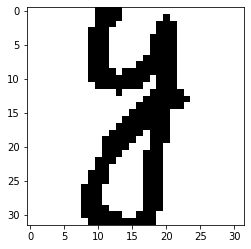

Predicted = y, Actual = y


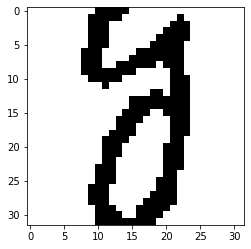

Predicted = y, Actual = y


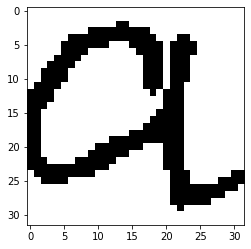

Predicted = a, Actual = a


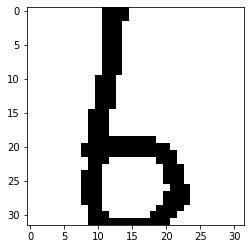

Predicted = b, Actual = b


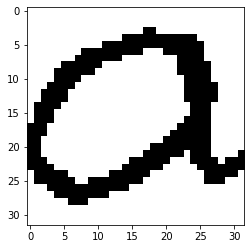

Predicted = a, Actual = a


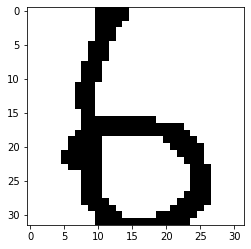

Predicted = b, Actual = b


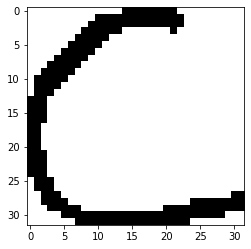

Predicted = c, Actual = c


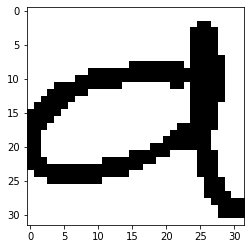

Predicted = a, Actual = a


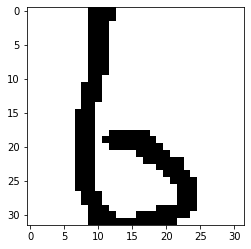

Predicted = b, Actual = b


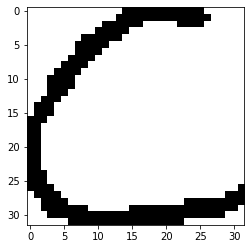

Predicted = c, Actual = c


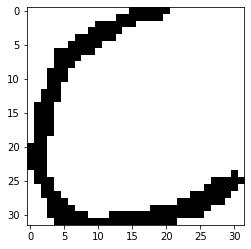

Predicted = c, Actual = c


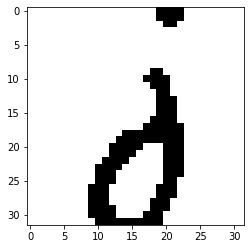

Predicted = i, Actual = j


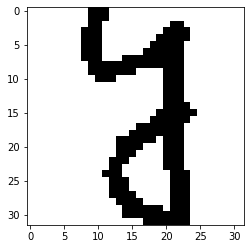

Predicted = y, Actual = y


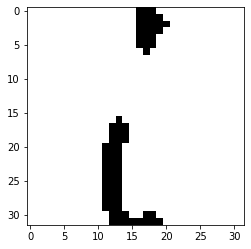

Predicted = i, Actual = i


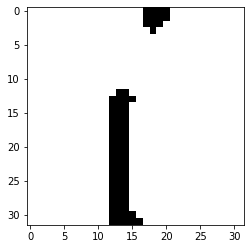

Predicted = i, Actual = i


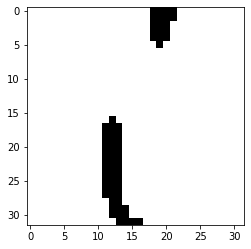

Predicted = i, Actual = i


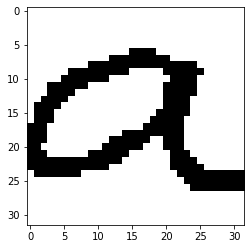

Predicted = a, Actual = a


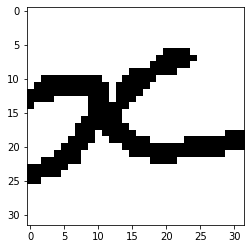

Predicted = x, Actual = x


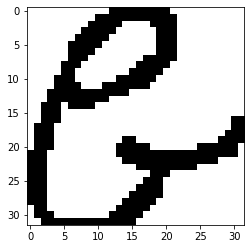

Predicted = q, Actual = b


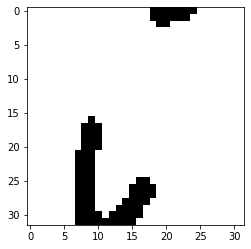

Predicted = i, Actual = i


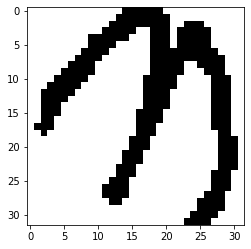

Predicted = n, Actual = n


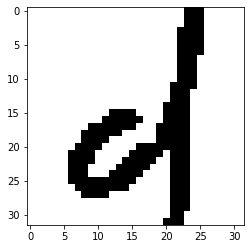

Predicted = d, Actual = d


In [13]:
test_data_iter = iter(test_loader)
data = test_data_iter.next()

test_features = data['features'].to(device)
labels = data['label'].to(device)

outputs = net(test_features)

_, predicted = torch.max(outputs.data, dim=1)

for f, l, p, in zip(test_features, labels, predicted):
    f = np.squeeze(f.cpu().numpy())
    plt.figure()
    plt.imshow(f, cmap='gray')
    plt.show()
    print(f'Predicted = {classes[p]}, Actual = {classes[l]}')

In [14]:
d['features']

NameError: name 'd' is not defined

In [ ]:
# Compute accuracy on the entire dataset.

correct = 0
total = 0
with torch.no_grad():
    for test_data in test_loader:
        test_features = test_data['features'].to(device)
        labels = test_data['label'].to(device)
        
        outputs = net(test_features)
        
        _, predicted = torch.max(outputs.data, dim=1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on test set: {correct / total * 100}%')